In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/

/content/drive


In [ ]:
!ls "/content/drive/MyDrive/DL Project/archive.zip"

'/content/drive/MyDrive/DL Project/archive.zip'


In [ ]:
!unzip "/content/drive/MyDrive/DL Project/archive.zip" -d "/content/drive/MyDrive/DL Project/10KExtract"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28056.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28081.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28160.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28181.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28190.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28192.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28194.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28197.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28199.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/train/real/28247.jpg  
  inflating: /content/drive/MyDrive/DL Project/10KExtract/rvf10k/trai

In [ ]:
#!mkdir -p "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/test_real"
#!mkdir -p "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/test_fake"

# Move 750 real images to test_real
#!find "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/real" -type f | head -1500 | xargs -I {} mv {} "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/test_real"

# Move 750 fake images to test_fake
#!find "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/fake" -type f | head -1500 | xargs -I {} mv {} "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/test_fake"

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!ls "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid"


fake  real  test_fake  test_real


In [ ]:
# Move 750 real images to test_real
!find "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/test_real" -type f | head -750 | xargs -I {} mv {} "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/real"

# Move 750 fake images to test_fake
!find "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/test_fake" -type f | head -750 | xargs -I {} mv {} "/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid/fake"

In [ ]:
# ImageDataGenerators with rescaling, and augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/DL Project/10KExtract/rvf10k/train',
    target_size=(299, 299),  # Xception default input size
    batch_size=32,
    class_mode='binary',
    classes=['real', 'fake'])

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    classes=['real', 'fake'])

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/DL Project/10KExtract/rvf10k/valid',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    classes=['test_real', 'test_fake'])

Found 7000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the base model

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust epochs based on your needs
)

Epoch 1/10
218/218 [==============================] - 247s 1s/step - loss: 0.6130 - accuracy: 0.6655 - val_loss: 0.5400 - val_accuracy: 0.7317
Epoch 2/10
218/218 [==============================] - 214s 982ms/step - loss: 0.5513 - accuracy: 0.7148 - val_loss: 0.5191 - val_accuracy: 0.7602
Epoch 3/10
218/218 [==============================] - 214s 982ms/step - loss: 0.5371 - accuracy: 0.7242 - val_loss: 0.5089 - val_accuracy: 0.7582
Epoch 4/10
218/218 [==============================] - 207s 949ms/step - loss: 0.5381 - accuracy: 0.7318 - val_loss: 0.5028 - val_accuracy: 0.7629
Epoch 5/10
218/218 [==============================] - 222s 1s/step - loss: 0.5136 - accuracy: 0.7433 - val_loss: 0.4970 - val_accuracy: 0.7595
Epoch 6/10
218/218 [==============================] - 219s 1s/step - loss: 0.4967 - accuracy: 0.7595 - val_loss: 0.4789 - val_accuracy: 0.7765
Epoch 7/10
218/218 [==============================] - 210s 961ms/step - loss: 0.4904 - accuracy: 0.7613 - val_loss: 0.4912 - val_accu

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

47/47 [==============================] - 12s 243ms/step - loss: 0.4607 - accuracy: 0.7867
Test Accuracy: 0.7866666913032532, Test Loss: 0.4606698453426361


In [ ]:
model.save('/content/drive/MyDrive//DL Project/Xception10KModel.keras')


In [ ]:
test_generator.shuffle = False
test_generator.reset()

predictions = model.predict(test_generator)
true_labels = test_generator.classes

import numpy as np
np.save('/content/drive/MyDrive//DL Project/predictions.npy', predictions)
np.save('/content/drive/MyDrive//DL Project/true_labels.npy', true_labels)

47/47 [==============================] - 13s 263ms/step


In [ ]:
import json

history_data = {
    "loss": history.history['loss'],
    "accuracy": history.history['accuracy'],
    "val_loss": history.history['val_loss'],
    "val_accuracy": history.history['val_accuracy']
}

with open('/content/drive/MyDrive//DL Project/xception_10K_training_history.json', 'w') as f:
    json.dump(history_data, f)

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_labels = test_generator.classes

47/47 [==============================] - 13s 263ms/step


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_classes, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.76      0.83      0.80       750
        Real       0.81      0.74      0.78       750

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



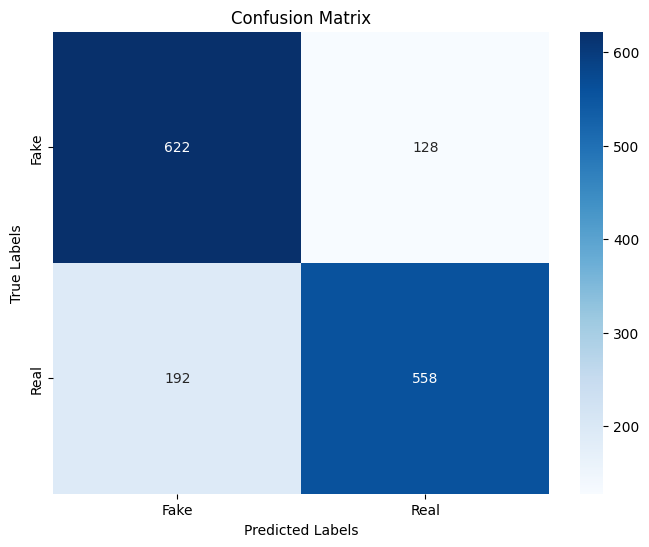

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

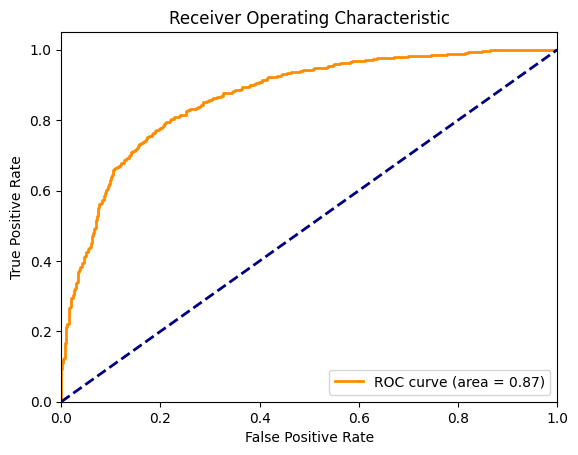

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

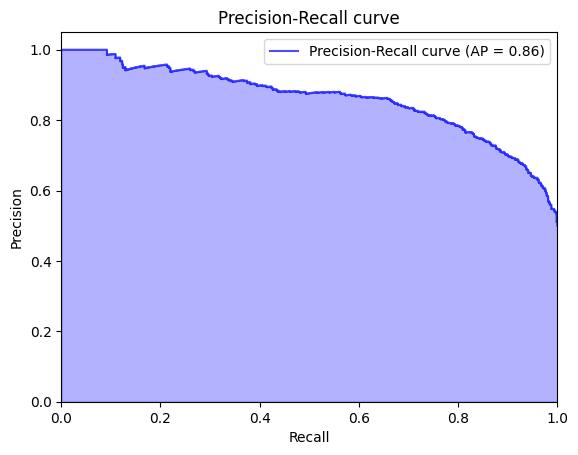

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(true_labels, predictions)
average_precision = average_precision_score(true_labels, predictions)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()